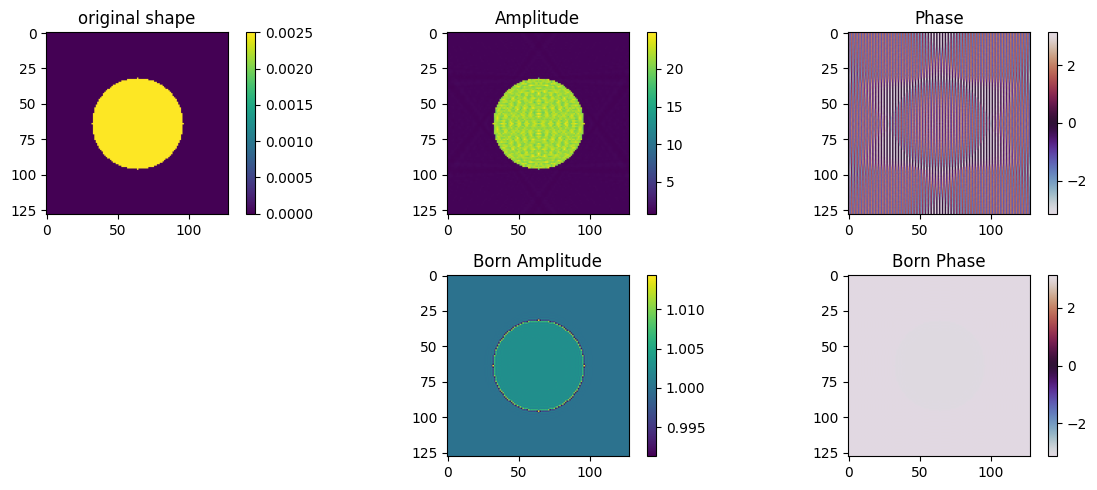

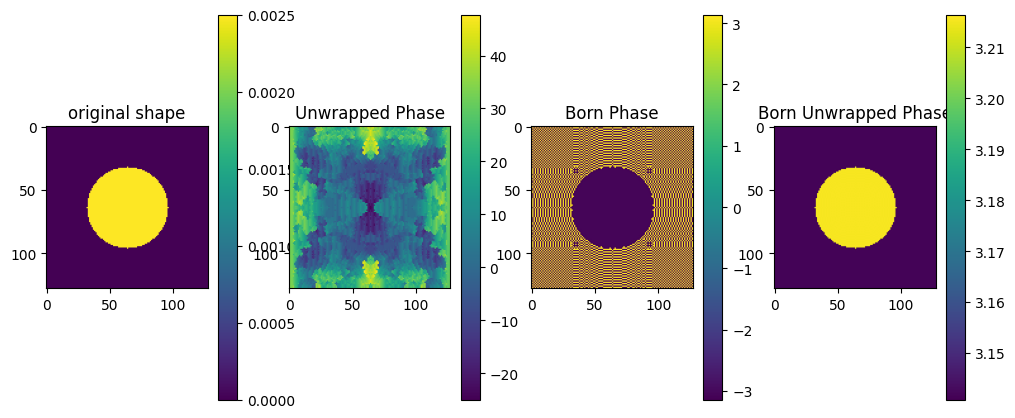

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel1
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
import math
import sys, os
import time

# -----------------------------
# 2D Green's function
# -----------------------------
def green2d(R, k):
    # 2D Green's function: H0^(1)(k*R)/(4i)
    # avoid singularity at R=0
    g = np.zeros_like(R, dtype=np.complex128)
    mask = R != 0
    g[mask] = 1j/4 * hankel1(0, k*R[mask])
    g[~mask] = 1j/4 * hankel1(0, k*1e-10)  # tiny R to avoid zero
    return g

# -----------------------------
# Padding helpers (like bornscat)
# -----------------------------
def pad_add(f):
    s = f.shape[0]
    f_pad = np.zeros((2*s, 2*s), dtype=f.dtype)
    f_pad[s//2:3*s//2, s//2:3*s//2] = f
    return f_pad

def pad_rem(u):
    s = u.shape[0] // 2
    return u[s//2:3*s//2, s//2:3*s//2]

# -----------------------------
# Born 2D
# -----------------------------
import numpy as np

def born_2d_fourier(n, lD, nm, lambd, zeropad=True):
    """
    Compute first Born approximation using Fourier convolution.
    Returns 2D complex field at distance lD.
    """
    km = 2*np.pi*nm/lambd
    f = km**2 * ((n/nm)**2 - 1)
    a0 = 1.0
    
    N = n.shape[0]
    if zeropad:
        order = int(2**np.ceil(np.log2(2*N)))
    else:
        order = N
    pads = order - N
    
    # zero pad
    f_pad = np.pad(f, ((pads//2,pads//2),(pads//2,pads//2)), mode='constant')
    
    # 2D FFT
    F = np.fft.fftshift(np.fft.fft2(f_pad))
    
    # spatial frequency grids
    kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(F.shape[0]))
    ky = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(F.shape[1]))
    
    # assume small-angle, approximate kz
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    kz = np.sqrt(np.maximum(km**2 - KX**2 - KY**2, 0)) - km
    
    # prefactor
    with np.errstate(divide='ignore', invalid='ignore'):
        M = np.sqrt(np.maximum(km**2 - KX**2 - KY**2, 0))/km
        prefactor = 1j * a0 / km * np.sqrt(np.pi/2) / M * np.exp(1j*km*M*lD)
        prefactor[~np.isfinite(prefactor)] = 0.0
    
    # multiply in Fourier space
    U = F * prefactor
    
    # inverse FFT
    uB_pad = np.fft.ifft2(np.fft.ifftshift(U))
    
    # crop back
    start = pads//2
    end = start + N
    uB = uB_pad[start:end, start:end]
    
    # add incident plane wave
    u = np.exp(1j*km*lD) + uB
    return u

# -----------------------------
# Rytov 2D
# -----------------------------
import numpy as np

def rytov_2d_bornscat_style(n, nm, lambd, lD=1.0, zeropad=True):
    """
    Bornscat-style 2D Rytov approximation, translated to pure NumPy.
    """
    km = (2*np.pi*nm)/lambd
    f = km**2 * ((n/nm)**2 - 1)
    a0 = 1

    ln = len(f)
    if zeropad:
        order = max(64, 2**np.ceil(np.log2(2*ln)))
        pads = int(order - ln)
    else:
        pads = 0

    f = np.pad(f, ((pads//2, pads//2), (pads//2, pads//2)), mode="constant")
    
    # 2D FFT of padded potential
    F = np.fft.fftshift(np.fft.fft2(f))
    
    # kx vector
    kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(F.shape[0]))
    # kz derived from dispersion
    kz = np.sqrt(np.maximum(km**2 - kx**2, 0)) - km
    
    # Filter to avoid NaNs
    filter_klp = (kx**2 < km**2)
    M_arr = np.zeros_like(kx)
    M_arr[filter_klp] = 1/km * np.sqrt(km**2 - kx[filter_klp]**2)

    # Prefactor
    prefactor = 1j * a0 / km * np.sqrt(np.pi/2) / M_arr * np.exp(1j*km*M_arr*lD)
    prefactor[~filter_klp] = 0

    # Interpolate F along kx -> kz line
    # Simplest replacement: linear interp along axis=0
    # For 2D F, we just take the diagonal slice F[kx_index, kx_index] as a rough approximation
    idx = np.arange(len(kx))
    Fdiag = np.diag(F)  # take the diagonal in 2D FFT plane
    Fintp = np.interp(kx, kx, Fdiag) + 0j  # linear interp (real-only; imaginary=0) 
    # This replaces LinearNDInterpolator in a simple way
    
    # Multiply by prefactor
    U = prefactor * Fintp

    # Inverse FFT to get field
    uB = np.fft.ifft(np.fft.ifftshift(U))

    # Add incident field
    u = np.exp(1j*km*lD) + uB
    return u


# -----------------------------
# Example phantom slice
# -----------------------------
N = 128
L = 80.0
px = L/N
x = np.linspace(-L/2, L/2 - px, N)
y = np.linspace(-L/2, L/2 - px, N)
z = np.linspace(-L/2, L/2 - px, N)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# ellipsoid slice
a, b, c = 20, 20, 10
dn = 0.0025
phantom = np.zeros((N,N))
phantom[((Y[:,:,N//2]/a)**2 + (X[:,:,N//2]/b)**2 <= 1)] = dn

# Compute Rytov field
nm = 1.33
lambd = 0.532
u = rytov_2d(phantom + nm, nm, lambd)
phase = np.angle(u)
u_b = born_2d_fourier(phantom + nm, lD=1.0, nm=nm, lambd=lambd)
phase_b = np.angle(u_b)

# Plot
plt.figure(figsize=(12,5))
plt.subplot(2,3,1)
plt.imshow(phantom, cmap='viridis')
plt.title('original shape')
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.abs(u), cmap='viridis')
plt.title('Amplitude')
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(np.angle(u), cmap='twilight')
plt.title('Phase')
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(np.abs(u_b), cmap='viridis')
plt.title('Born Amplitude')
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(phase_b, cmap='twilight')
plt.title('Born Phase')
plt.colorbar()
plt.tight_layout()
plt.show()

# 2. Smooth the complex field slightly
u_smooth = gaussian_filter(np.real(u), 1) + 1j*gaussian_filter(np.imag(u), 1)

# 3. Compute phase
phi = np.angle(u_smooth)

# 4. Mask low amplitude regions
mask = np.abs(u) > 0.1
phi[~mask] = 0

# 5. Unwrap
from skimage.restoration import unwrap_phase
phi_unwrapped = unwrap_phase(phi)
phi_unwrapped_b = unwrap_phase(phase_b)

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,4,1)
plt.imshow(phantom, cmap='viridis')
plt.title('original shape')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(phi_unwrapped, cmap='viridis')
plt.title('Unwrapped Phase')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(phase_b, cmap='viridis')
plt.title('Born Phase')
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(phi_unwrapped_b, cmap='viridis')
plt.title('Born Unwrapped Phase')
plt.colorbar()
plt.show()
